### Trained Models Comparison

In [1]:
import torch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Model Initialization

In [3]:
import torch.nn as nn
import torch.nn.functional as F

##### 1. U-Net

In [4]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(1, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.middle = conv_block(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        m = self.middle(self.pool(e3))

        d3 = self.up3(m)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return torch.sigmoid(self.final(d1))

In [5]:
unet_model = UNet() 
unet_model.load_state_dict(torch.load("../models/unet.pth", map_location = device))
unet_model = unet_model.to(device)
unet_model.eval()

UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (middle): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

##### 2. SegNet

In [6]:
class SegNet(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 1):
        super().__init__()

        def encoder_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace = True),
                nn.Conv2d(out_c, out_c, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace = True),
                nn.MaxPool2d(2, 2, return_indices = True)  # Save indices for unpooling
            )

        def decoder_block(in_c, out_c):
            return nn.Sequential(
                nn.MaxUnpool2d(2, 2),
                nn.Conv2d(in_c, out_c, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace = True),
                nn.Conv2d(out_c, out_c, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace = True),
            )

        self.enc1 = encoder_block(in_channels, 64)
        self.enc2 = encoder_block(64, 128)
        self.enc3 = encoder_block(128, 256)

        self.dec3 = decoder_block(256, 128)
        self.dec2 = decoder_block(128, 64)
        self.dec1 = nn.Sequential(
            nn.MaxUnpool2d(2, 2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
        )

    def forward(self, x):
        e1, ind1 = self.enc1(x)
        e2, ind2 = self.enc2(e1)
        e3, ind3 = self.enc3(e2)

        d3 = self.dec3[0](e3, ind3)  # MaxUnpool2d with indices
        d3 = self.dec3[1:](d3)

        d2 = self.dec2[0](d3, ind2)
        d2 = self.dec2[1:](d2)

        d1 = self.dec1[0](d2, ind1)
        d1 = self.dec1[1:](d1)

        if self.dec1[-1].out_channels == 1:
            return torch.sigmoid(d1)
        else:
            return d1  # logits for multi-class

In [7]:
segnet_model = SegNet()
segnet_model.load_state_dict(torch.load("../models/segnet.pth", map_location = device))
segnet_model = segnet_model.to(device)
segnet_model.eval()

SegNet(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )


##### 3. Swin U-Net

In [8]:
import timm

c:\Users\PC\anaconda3\envs\main-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
swin = timm.create_model('swin_base_patch4_window7_224', pretrained = False, features_only = True)

In [10]:
class UNetDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(768, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(384, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(192, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, features):
        e1, e2, e3, e4 = features  # e4 is reduced 512 channels

        d3 = self.up3(e4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))  # concat 256 + 512 = 768

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))  # concat 128 + 256 = 384

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))  # concat 64 + 128 = 192

        out = F.interpolate(d1, scale_factor=4, mode='bilinear', align_corners=False)
        return torch.sigmoid(self.final(out))

In [11]:
class SwinUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = swin
        self.channel_reducer = nn.Conv2d(1024, 512, kernel_size=1)
        self.decoder = UNetDecoder()

    def forward(self, x):
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        features = self.encoder(x)
        features = [self._to_channels_first(f) for f in features]

        features[3] = self.channel_reducer(features[3])

        output = self.decoder(features)
        return output

    def _to_channels_first(self, feature):
        if feature.dim() == 4:
            return feature.permute(0, 3, 1, 2).contiguous()
        elif feature.dim() == 3:
            B, N, C = feature.shape
            H = W = int(N ** 0.5)
            feature = feature.permute(0, 2, 1).contiguous()
            return feature.view(B, C, H, W)
        else:
            raise ValueError(f"Unexpected feature shape: {feature.shape}")


In [12]:
swinunet_model = SwinUNet()
swinunet_model.load_state_dict(torch.load("../models/swinunet.pth", map_location = device))
swinunet_model = swinunet_model.to(device)
swinunet_model.eval()

SwinUNet(
  (encoder): FeatureListNet(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (layers_0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')


##### 4. SegFormer

In [13]:
from transformers import SegformerForSemanticSegmentation

In [14]:
segformer_model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b5-finetuned-ade-640-640",
    num_labels = 1, 
    ignore_mismatched_sizes = True
)

segformer_model.load_state_dict(torch.load("../models/segformer.pth", map_location = device))
segformer_model = segformer_model.to(device)
segformer_model.eval()

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b5-finetuned-ade-640-640 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([1, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

### Comparison

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as T
import random
from PIL import Image
from skimage.transform import resize

In [16]:
transform = T.Compose([
    T.ToTensor(), 
    T.Resize((224, 224)),
])

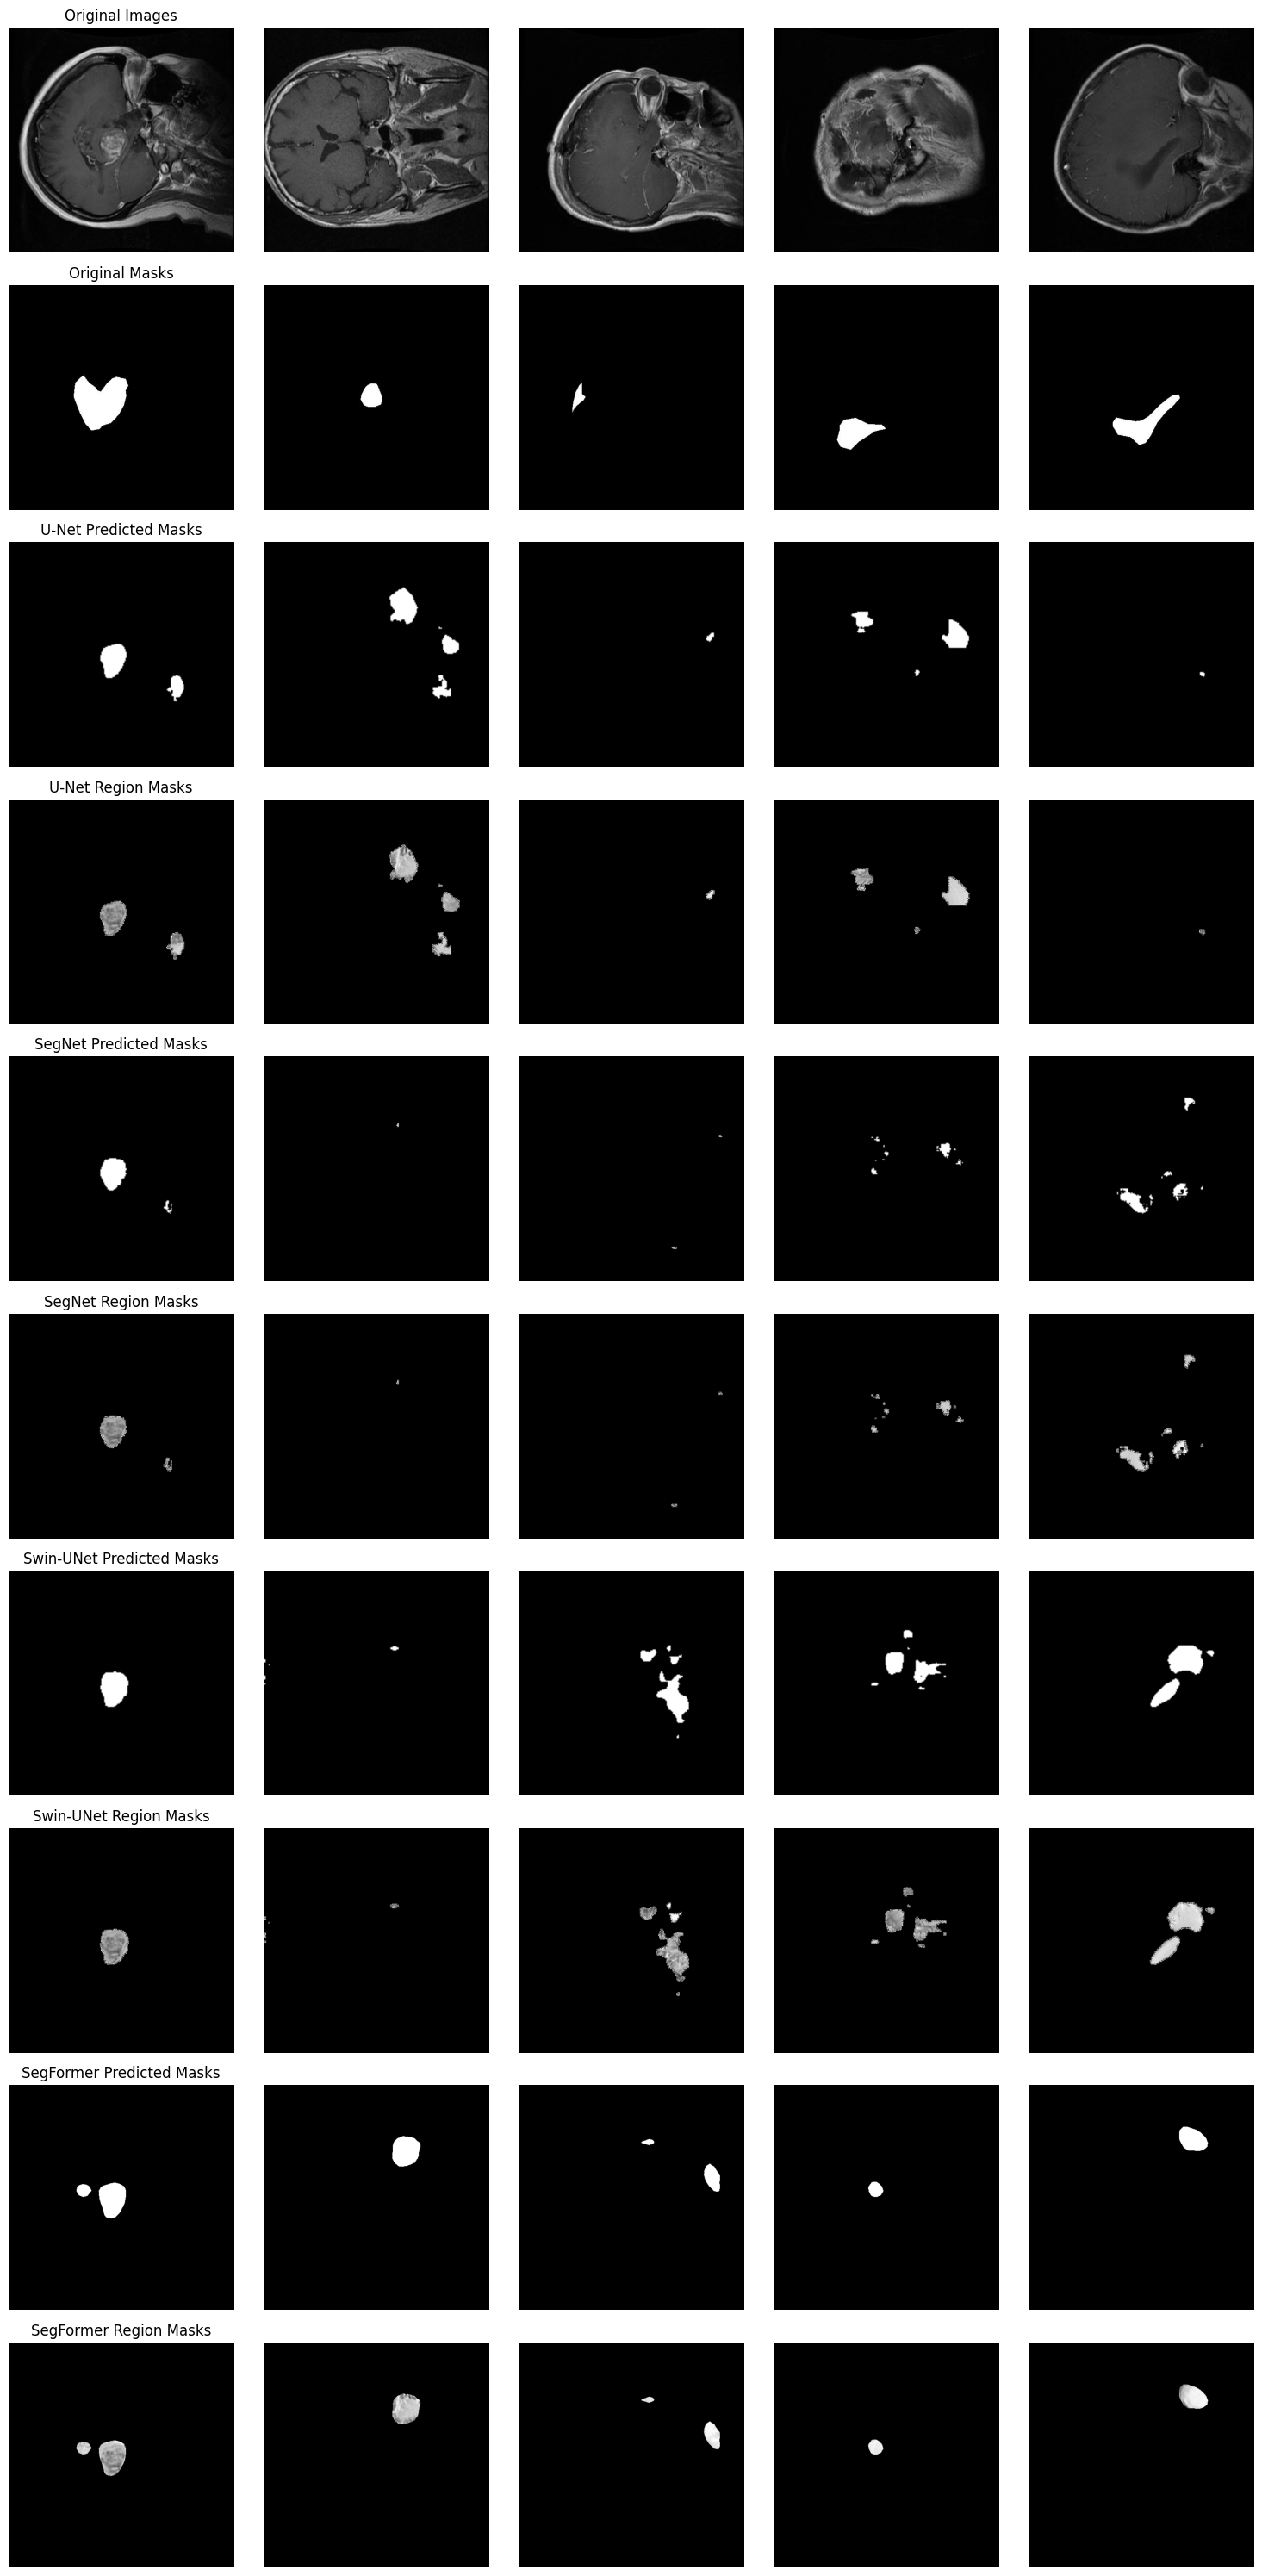

In [ ]:
# Define the region extraction function
def extract_region(image, mask):
    normalized_mask = mask
    extracted_region = image * normalized_mask
    return extracted_region

# Set data directory and list image files
data_dir = "../data/converted"
file_names = [f for f in os.listdir(f"{data_dir}/images")]
random.shuffle(file_names)
file_names = file_names[:5]

plt.figure(figsize=(15, 30))

for idx, file_name in enumerate(file_names):
    image_path = os.path.join(f"{data_dir}/images", file_name)
    mask_path = os.path.join(f"{data_dir}/masks/{file_name}")

    # Load and transpose image and mask
    image = np.array(Image.open(image_path)).T
    mask = np.array(Image.open(mask_path)).T

    # Prepare input tensor
    input_tensor = transform(image)
    input_tensor = input_tensor.unsqueeze(0).to(device)

    # Model predictions
    with torch.no_grad():
        unet_output = (unet_model(input_tensor) > 0.5).float()
        segnet_output = (segnet_model(input_tensor) > 0.5).float()
        swinunet_output = (swinunet_model(input_tensor) > 0.5).float()

        segformer_input = input_tensor.repeat(1, 3, 1, 1)  # make it 3-channel if needed
        segformer_output = segformer_model(segformer_input).logits
        segformer_output = nn.functional.interpolate(
            segformer_output,
            size=image.shape[-2:],
            mode="bilinear",
            align_corners=False
        )
        segformer_output = (segformer_output > 0.5).float()

    # Convert all outputs to NumPy
    unet_output_np = unet_output.squeeze().cpu().numpy() * 255
    segnet_output_np = segnet_output.squeeze().cpu().numpy() * 255
    swinunet_output_np = swinunet_output.squeeze().cpu().numpy() * 255
    segformer_output_np = segformer_output.squeeze().cpu().numpy() * 255

    unet_output_np = resize(unet_output_np, image.shape, preserve_range=True).astype(np.uint8)
    segnet_output_np = resize(segnet_output_np, image.shape, preserve_range=True).astype(np.uint8)
    swinunet_output_np = resize(swinunet_output_np, image.shape, preserve_range=True).astype(np.uint8)
    segformer_output_np = resize(segformer_output_np, image.shape, preserve_range=True).astype(np.uint8)

    row_offset = 0

    # 1. Original Images
    plt.subplot(10, 5, idx + 1 + row_offset)
    plt.imshow(image, cmap="gray")
    if idx == 0:
        plt.title("Original Images")
    plt.axis("off")

    # 2. Original Masks
    row_offset += 5
    plt.subplot(10, 5, idx + 1 + row_offset)
    plt.imshow(mask, cmap="gray")
    if idx == 0:
        plt.title("Original Masks")
    plt.axis("off")

    # 3. U-Net Predicted Masks
    row_offset += 5
    plt.subplot(10, 5, idx + 1 + row_offset)
    plt.imshow(unet_output_np, cmap="gray")
    if idx == 0:
        plt.title("U-Net Predicted Masks")
    plt.axis("off")

    # 4. U-Net Region Masks
    row_offset += 5
    plt.subplot(10, 5, idx + 1 + row_offset)
    plt.imshow(extract_region(image, unet_output_np), cmap="gray")
    if idx == 0:
        plt.title("U-Net Region Masks")
    plt.axis("off")

    # 5. SegNet Predicted Masks
    row_offset += 5
    plt.subplot(10, 5, idx + 1 + row_offset)
    plt.imshow(segnet_output_np, cmap="gray")
    if idx == 0:
        plt.title("SegNet Predicted Masks")
    plt.axis("off")

    # 6. SegNet Region Masks
    row_offset += 5
    plt.subplot(10, 5, idx + 1 + row_offset)
    plt.imshow(extract_region(image, segnet_output_np), cmap="gray")
    if idx == 0:
        plt.title("SegNet Region Masks")
    plt.axis("off")

    # 7. Swin-UNet Predicted Masks
    row_offset += 5
    plt.subplot(10, 5, idx + 1 + row_offset)
    plt.imshow(swinunet_output_np, cmap="gray")
    if idx == 0:
        plt.title("Swin-UNet Predicted Masks")
    plt.axis("off")

    # 8. Swin-UNet Region Masks
    row_offset += 5
    plt.subplot(10, 5, idx + 1 + row_offset)
    plt.imshow(extract_region(image, swinunet_output_np), cmap="gray")
    if idx == 0:
        plt.title("Swin-UNet Region Masks")
    plt.axis("off")

    # 9. SegFormer Predicted Masks
    row_offset += 5
    plt.subplot(10, 5, idx + 1 + row_offset)
    plt.imshow(segformer_output_np, cmap="gray")
    if idx == 0:
        plt.title("SegFormer Predicted Masks")
    plt.axis("off")

    # 10. SegFormer Region Masks
    row_offset += 5
    plt.subplot(10, 5, idx + 1 + row_offset)
    plt.imshow(extract_region(image, segformer_output_np), cmap="gray")
    if idx == 0:
        plt.title("SegFormer Region Masks")
    plt.axis("off")

plt.tight_layout()
plt.show()


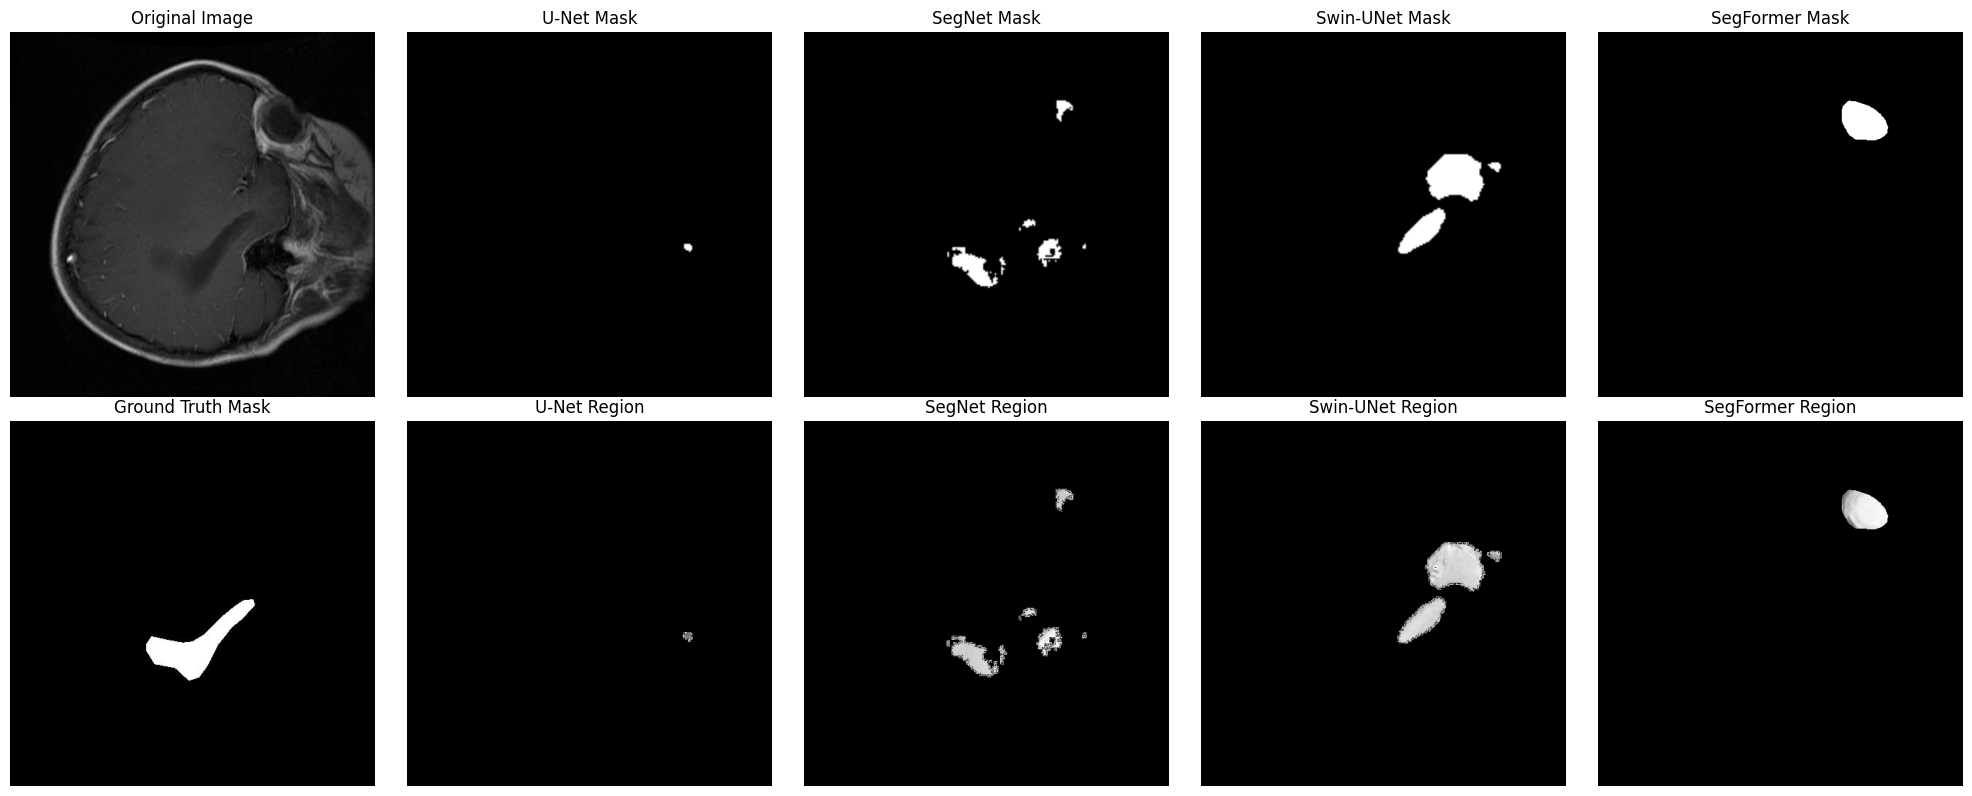

In [19]:
# Plotting
plt.figure(figsize=(20, 8))

# Row 1: Original + Predicted Masks
titles_row1 = ["Original Image", "U-Net Mask", "SegNet Mask", "Swin-UNet Mask", "SegFormer Mask"]
images_row1 = [image, unet_output_np, segnet_output_np, swinunet_output_np, segformer_output_np]

# Row 2: Ground Truth + Region Extracted
titles_row2 = ["Ground Truth Mask", "U-Net Region", "SegNet Region", "Swin-UNet Region", "SegFormer Region"]
images_row2 = [
    mask,
    extract_region(image, unet_output_np),
    extract_region(image, segnet_output_np),
    extract_region(image, swinunet_output_np),
    extract_region(image, segformer_output_np),
]

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images_row1[i], cmap="gray")
    plt.title(titles_row1[i])
    plt.axis("off")

    plt.subplot(2, 5, i + 6)
    plt.imshow(images_row2[i], cmap="gray")
    plt.title(titles_row2[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

### Export

In [20]:
from tqdm import tqdm

In [34]:
# CHANGE DIR AS NEEDED
base_dir = "../data/dataset"
input_root = os.path.join(base_dir, "normal")
output_root = os.path.join(base_dir, "original")

In [22]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor() 
])

In [36]:
def extract_region(image_tensor, mask_tensor):
    return image_tensor * mask_tensor  # Both shape: [1, H, W]

# Loop over dataset
for phase in ["Training", "Testing"]:
    phase_path = os.path.join(input_root, phase)
    for tumor_type in os.listdir(phase_path):
        tumor_path = os.path.join(phase_path, tumor_type)
        output_dir = os.path.join(output_root, phase, tumor_type)
        os.makedirs(output_dir, exist_ok=True)

        for filename in tqdm(os.listdir(tumor_path), desc=f"{phase}/{tumor_type}"):
            if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            # Load image
            image_path = os.path.join(tumor_path, filename)
            image = Image.open(image_path).convert("L")
            image_tensor = transform(image).unsqueeze(0).to(device)  # [1, 1, 224, 224]

            # Predict mask
            # with torch.no_grad():
            #     ### CHANGE MODEL AS NEEDED
            #     # mask_pred = (segnet_model(image_tensor) > 0.5).float()  # [1, 1, 224, 224]
            #     mask_pred = segformer_model(input_tensor.repeat(1, 3, 1, 1)).logits
            #     mask_pred = nn.functional.interpolate(mask_pred, size=image_tensor.shape[-2:], mode="bilinear", align_corners=False)
            #     mask_pred = (mask_pred > 0.5).float()
            # # Extract region
            # extracted = extract_region(image_tensor, mask_pred)  # [1, 1, 224, 224]

            # # Convert to numpy image
            extracted_img = image_tensor.squeeze().cpu().numpy() * 255
            extracted_img = Image.fromarray(extracted_img.astype(np.uint8))

            # Save
            save_path = os.path.join(output_dir, os.path.splitext(filename)[0] + ".png")
            extracted_img.save(save_path)

Testing/pituitary: 100%|██████████| 300/300 [00:01<00:00, 267.34it/s]
